In [1]:
import torch
import torch.nn as nn

from torch import optim
from torch.autograd import Variable
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from utils.CvTransform import CvResize, CvCenterCrop

import torch.utils.data

from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import ImgToSeq
from dataset.readVideo import DramaDataset
useCuda = False
device = torch.device("cuda" if useCuda else "cpu")

In [2]:
DataDir="/home/ball/Videos/BrokeEN"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=2,
                        )
transform = transforms.Compose([CvResize(256),
                                            CvCenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])
len(datasets)

Total Drama: 113


39335

In [3]:
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

In [13]:
import matplotlib.pyplot as plt
UF = nn.functional.upsample
crop = transforms.Compose([CvResize(256),CvCenterCrop(224)])
def getConvLast(cmodal, img):
    c1 = cmodal.conv1(img)
    c1 = cmodal.relu(cmodal.bn1(c1))
    c1 = cmodal.maxpool(c1)
    c2 = cmodal.layer1(c1)
    c3 = cmodal.layer2(c2)
    c4 = cmodal.layer3(c3)
    c5 = cmodal.layer4(c4)
    return c5

def showHeatMap(imgs, lcs):
    heatmap = torch.sum(lcs, 1)
    heatmap = UF(heatmap.unsqueeze(1), (224,224), mode="bilinear", align_corners=True)[:,0,:]
    
    col=5
    plt.figure(figsize=(20,10))
    for i in range(len(imgs)):
        plt.subplot(len(imgs)/col+1,col,i+1)
        plt.axis('off')
        plt.imshow(crop(imgs[i]))
        plt.imshow(heatmap[i].data, cmap='hot', alpha=0.55)
    plt.show()
def showImgs(imgs):
    col=5
    plt.figure(figsize=(20,10))
    for i in range(len(imgs)):
        plt.subplot(len(imgs)/col+1,col,i+1)
        plt.axis('off')
        plt.imshow(imgs[i])
    plt.show()

In [5]:
def predit(model, lang, imgs, subtitle, max_length=50):
    ans = []
    probs = []
    inputImgs = imgs.unsqueeze(0).to(device)
    subtitle = torch.LongTensor(lang.sentenceToVector(subtitle, sos=False, eos=False)).unsqueeze(0).to(device)
    inputs = torch.LongTensor([[lang["SOS"]]]).long().to(device)
    
    hidden = None
    
    cxt = model.makeContext(inputImgs, subtitle)
    for i in range(max_length):
        outputs, hidden = model.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        probs.append(prob.item())

        if(outputs.item() == lang["EOS"]):
            break
        ans.append(outputs.item())

        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans), probs

def mutilePredit(pres, nexs, imgs):
    makes = []
    for pre, nex, img in zip(pres, nexs, imgs):
        mk = predit(model, lang, transform(img[0]).unsqueeze(0), pre)
        makes.append(mk[0])
    return makes

def toBatchFirst(outputs):
    nep = len(outputs)
    nbatch = len(outputs[0])
    bFirst = []
    for b in range(nbatch):
        bdatas = []
        for e in range(nep):
            bdatas.append(outputs[e][b])
        bFirst.append(bdatas)
    return bFirst

In [6]:
import pickle
import os
ModelDir = "ImgSub2Sub/models/bken_tanh4.0"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SubImgModel.3.pth")).to(device).eval()
cnn = model.videoRnn.cnn.eval()

Load lang model: ImgSub2Sub/models/bken_tanh4.0. Word size: 15479


In [7]:
import torchvision.models as models
npcnn = models.resnet50(pretrained=False).to(device).eval()
pcnn = models.resnet50(pretrained=True).to(device).eval()

In [8]:
pres, nexs, imgs = getSample(10)

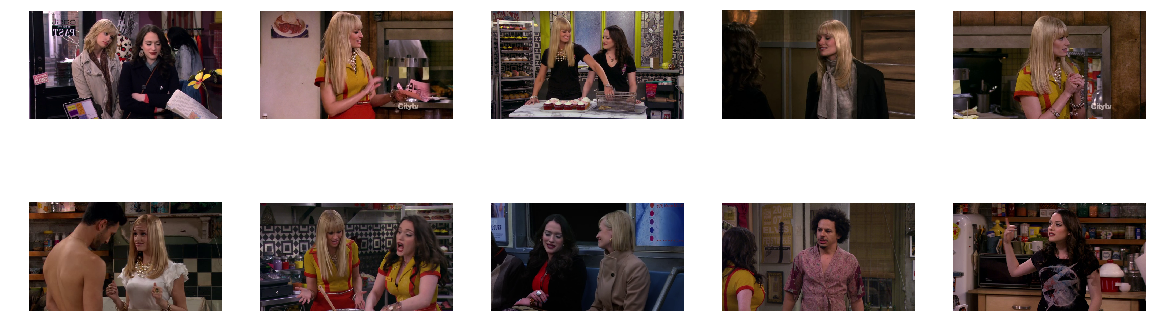

In [9]:
oimgs = [i[0] for i in imgs]
tImgs = Variable(torch.stack([transform(i) for i in oimgs]))
cImgs = [crop(i) for i in oimgs]
showImgs(oimgs)

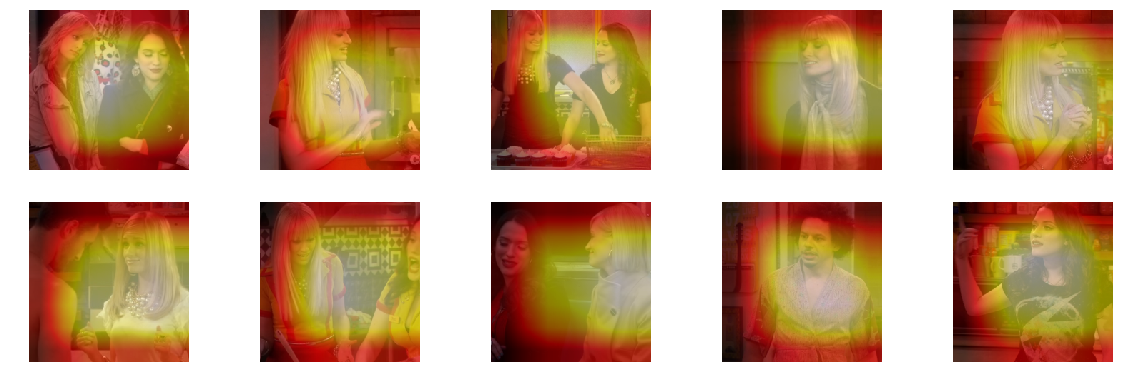

In [10]:
c5 = getConvLast(cnn, tImgs)
showHeatMap(oimgs, c5[:,:,:,:])

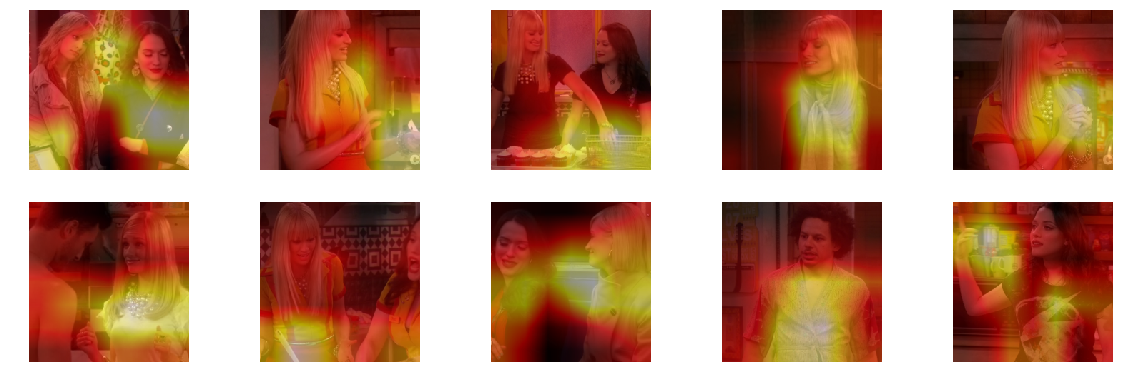

In [11]:
c5 = getConvLast(pcnn, tImgs)
showHeatMap(oimgs, c5[:,:,:,:])

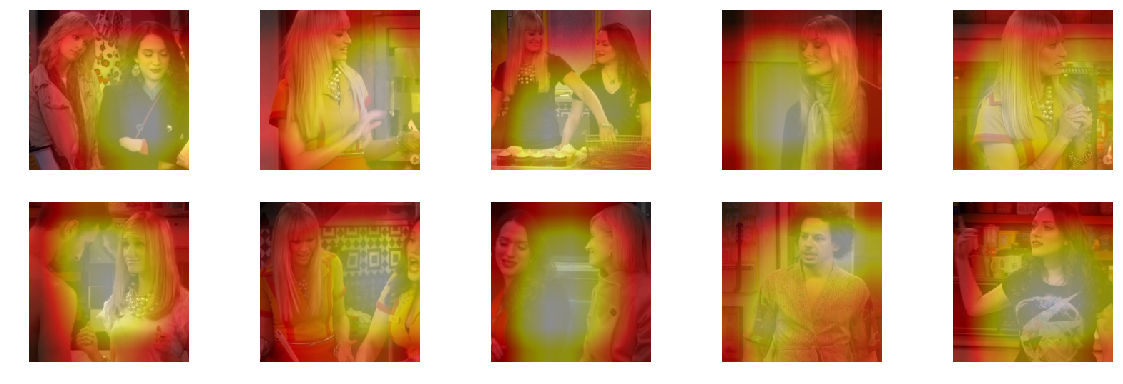

In [12]:
c5 = getConvLast(npcnn, tImgs)
showHeatMap(oimgs, c5[:,:,:,:])